### Choice of robustness metrics:


| Robustness metric 	 | value 	 |
|:-------------------:|:-------:|
|   test          	   | 0    	  |
|          	          |    	    |
|          	          |    	    |


First, packages are imported.

In [1]:
#   import packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle
import functools

from ema_workbench import (
    Model,
    Policy,
    Scenario,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    util,
    ScalarOutcome,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
from ema_workbench.em_framework import parameters_from_csv
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.em_framework.evaluators import BaseEvaluator

Then, the model is loaded, and logging is set.

In [2]:
dike_model, planning_steps = get_model_for_problem_formulation(5)
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

The results from the basecase open exploration, which includes the worst scenarios, are loaded into a Pandas DataFrame.

In [3]:
open_exploration_results = pd.read_pickle(r'generated_datasets\open_exploration_base_policy_worst_scenarios.pkl')

To calculate the robustness metrics, which are defined as the total annual damage, total expected number of deaths, total dike investment costs, total room for the river costs and total expected evacuation costs, lists of these variables are saved for later use.

In [4]:
# List the names of vars to make `robustness_functions` a bit more read-able
var_list_damage = ['A.1_Expected Annual Damage',
                   'A.2_Expected Annual Damage',
                   'A.3_Expected Annual Damage',
                   'A.4_Expected Annual Damage',
                   'A.5_Expected Annual Damage',]
var_list_deaths = ['A.1_Expected Number of Deaths',
                   'A.2_Expected Number of Deaths',
                   'A.3_Expected Number of Deaths',
                   'A.4_Expected Number of Deaths',
                   'A.5_Expected Number of Deaths',]
var_list_dike = ['A.1_Dike Investment Costs',
                 'A.2_Dike Investment Costs',
                 'A.3_Dike Investment Costs',
                 'A.4_Dike Investment Costs',
                 'A.5_Dike Investment Costs',]
var_list_rfr = ['RfR Total Costs',]
var_list_evac = ['Expected Evacuation Costs',]

Then, the robustness metric is initiated into a function. For this, we chose LEG UIT.
Furthermore, maximalization and minimalization functions are initiated to use in the optimization process.

In [5]:
def robust_sum(*data):
    sumsumsum = sum(sum(sum(data)))

    # we moeten nog een bron vinden waarom we deze metric gebruiken!
    mean = np.mean(sumsumsum)
    iqr = sp.stats.iqr(sumsumsum) + mean * 0.005
    result = mean + iqr

    return result


# robustness metrics
maximize = ScalarOutcome.MAXIMIZE
minimize = ScalarOutcome.MINIMIZE

Then, we make the robustness functions and add constraints. CONSTRAINTS STILL NEED TO BE DONE IF WE DECIDE TO DO SO.

In [6]:
robustness_functions = [
    ScalarOutcome('Damage Cost',
                  variable_name=var_list_damage,
                  function=robust_sum,
                  kind=minimize,
                  expected_range=(0, 4e16)),
    ScalarOutcome('Deaths Score',
                  variable_name=var_list_deaths,
                  function=robust_sum,
                  kind=minimize,
                  expected_range=(0, 8.5e19)),
    ScalarOutcome('Dike Invest Cost',
                  variable_name=var_list_dike,
                  function=robust_sum,
                  kind=minimize,
                  expected_range=(1e18, 1.3e7)),
    ScalarOutcome("RfR Invest Cost",
                  kind=minimize,
                  function=robust_sum,
                  variable_name="RfR Total Costs"),
    ScalarOutcome("Evacuation Cost",
                  kind=minimize,
                  function=robust_sum,
                  variable_name="Expected Evacuation Costs"),
]

# constraints = [
#     Constraint()
# ]

These scenarios are then loaded into a model variable.

In [7]:
scenarios = []
for row_number in range(open_exploration_results.shape[0]):
    scenarios.append(
        Scenario(name=row_number, **open_exploration_results.iloc[row_number, :16].to_dict())
    )

Convergence metrics are loaded

In [8]:
convergence_metrics = [
    ArchiveLogger(
        "./archives",
        [l.name for l in dike_model.levers],
        [o.name for o in robustness_functions],
        base_filename="robust_optimization_test.tar.gz",
    ),
    EpsilonProgress(),
]

Finally, the model variables are set.

In [9]:
# general input
nfe = 20 #make this large
epsilons = [0.05, ]*len(robustness_functions)

Then, the model can be run. Results are saved.

In [10]:
# Run MORO
with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustness_functions,
                                                     scenarios=scenarios,
                                                     nfe=nfe,
                                                     epsilons=epsilons,
                                                     convergence=convergence_metrics,
                                                     population_size=5,
                                                     )

# Write the results so this step can be skipped when doing multiple analyzes
with open(r'generated_datasets/initial_Pareto_policies_test.pkl', 'wb') as file_pi:
    pickle.dump(results, file_pi)

[MainProcess/INFO] pool started with 12 workers
23it [00:21,  1.05it/s]                                                        
[MainProcess/INFO] optimization completed, found 11 solutions
[MainProcess/INFO] terminating pool


Now, we can continue with the visualization. This part does not work at all, and needs a lot of work still.

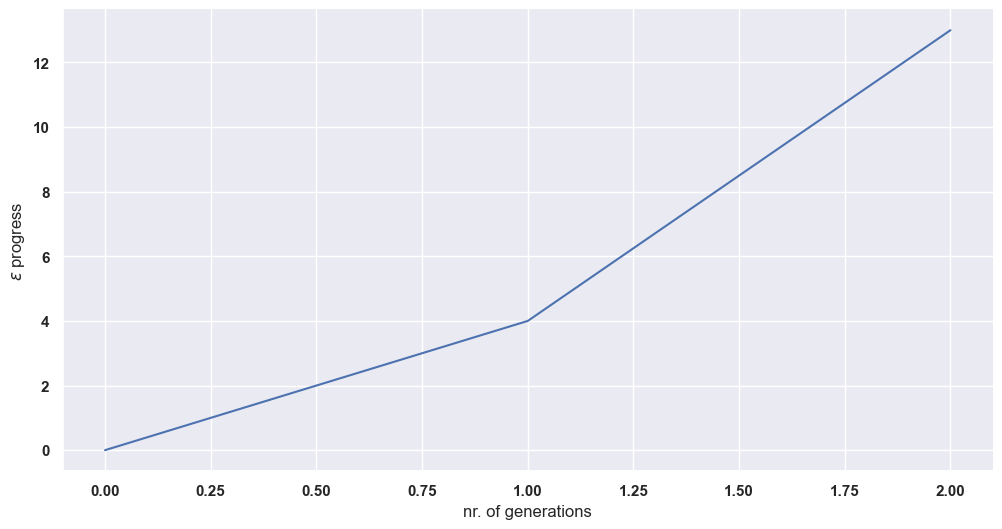

In [91]:

plt.plot(convergence.epsilon_progress)
plt.xlabel("nr. of generations")
plt.ylabel(r"$\epsilon$ progress")
sns.despine()
plt.show()
sns.set(rc={'figure.figsize':(12,6)})

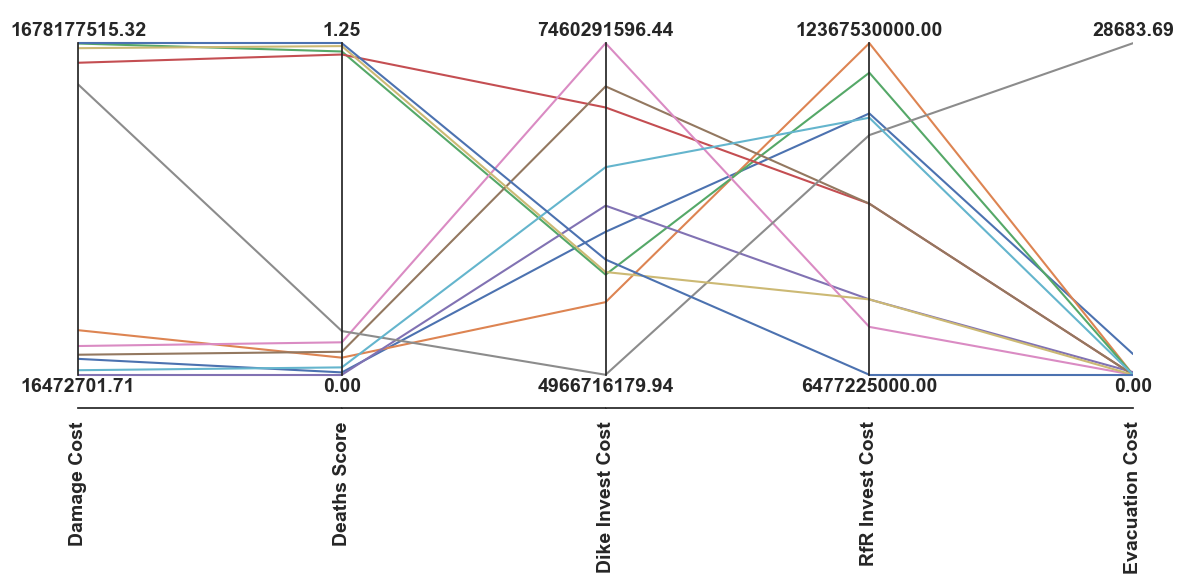

In [88]:
from ema_workbench.analysis import parcoords


df = pd.read_pickle(r'generated_datasets/initial_Pareto_policies_test.pkl')
data = df.loc[:, [o.name for o in robustness_functions]]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
sns.despine()
sns.set(rc={'figure.figsize':(12,6)})

In [11]:
# Extract the levers for each Pareto policy
policies = []
for row in range(results.shape[0]):
    policies.append(
        # Do not include the damage scores
        Policy(name=row, **results.iloc[row, :-5].to_dict())
    )

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=50, policies=policies)

# Write the results so this step can be skipped when doing multiple analyzes
with open('Outcomes/epsilon_results.pkl', 'wb') as file_pi:
    pickle.dump(results, file_pi)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 50 scenarios * 11 policies * 1 model(s) = 550 experiments
100%|████████████████████████████████████████| 550/550 [00:55<00:00,  9.97it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


FileNotFoundError: [Errno 2] No such file or directory: 'Outcomes/epsilon_results.pkl'